In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/widsdatathon2022/train.csv
/kaggle/input/widsdatathon2022/test.csv
/kaggle/input/widsdatathon2022/sample_solution.csv


![Climate change](https://assets.nrdc.org/sites/default/files/styles/header_background--retina/public/personalaction-kidsclimatechange-2400x1600.jpg?itok=PeSlNGgX)

## Business Problem

Climate change is a globally relevant, urgent, and multi-faceted issue heavily impacted by energy policy and infrastructure. Addressing climate change involves mitigation (i.e. mitigating greenhouse gas emissions) and adaptation (i.e. preparing for unavoidable consequences). Mitigation of GHG emissions requires changes to electricity systems, transportation, buildings, industry, and land use.

According to a report issued by the International Energy Agency (IEA), the lifecycle of buildings from construction to demolition were responsible for 37% of global energy-related and process-related CO2 emissions in 2020. Yet it is possible to drastically reduce the energy consumption of buildings by a combination of easy-to-implement fixes and state-of-the-art strategies. For example, retrofitted buildings can reduce heating and cooling energy requirements by 50-90 percent. Many of these energy efficiency measures also result in overall cost savings and yield other benefits, such as cleaner air for occupants. This potential can be achieved while maintaining the services that buildings provide.

In [2]:
#import necessary liabries for data exploration
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import itertools
import math
import time
import pickle

import statsmodels.api as sm
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from scipy import stats
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures 
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVR
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor

I will be bringing in one of the functions I used for one of my projects, it is going to be useful throughout the training process to evaluate the model.

In [3]:
#Function to assist with evaluating the models
def evaluate (estimator, X_train,y_train, X_val, y_val):
    """
    Evaluate the amount of error between the model's predictions 
    and actiual values for both train and test set
    
    Parameters:
    y_train - array like, actual values for 'price' 
    train_preds - array like predicted values for 'price'
    y_val/test -array like actual values for 'price'
    val_preds/test - array like predicted values for 'price'
    returns:
    None
    """
    
   #predict the target on the training and validation data
    train_preds = estimator.predict(X_train)
    val_preds = estimator.predict(X_val)
    
    print("Scores")
    
    print(f"Train score: {train_preds}") #training score
    print(f"validation score: {val_preds}") #validation/Test score
    
    print("Rsquared:")

    print(f"Train R2: {r2_score(y_train,train_preds):.4f}") #rsquare metrics for train
    print(f"Validation R2: {r2_score(y_val,val_preds):.4f}") #rsquare metrics for val/test

    print("-----")

    print("Root Mean squared Error:")

    print(f"Train RMSE: {mean_squared_error(y_train,train_preds,squared = False):.2f}") #rmse metrics for train
    print(f"Validation RMSE: {mean_squared_error(y_val,val_preds, squared = False):.2f}") #rmse metrics for val/test

    print("-----")

    print(" Mean absolute Error:")

    print(f"Train MAE: {mean_absolute_error(y_train,train_preds):.2f}") #MAE metrics for train
    print(f"Validation MAE: {mean_absolute_error(y_val,val_preds):.2f}") #MAE metrics for val/test
    
    #calculate the residual
    train_residual = y_train - train_preds #residual for train
    val_residual = y_val - val_preds #residual for val / test
    
    #QQplot to check the normality of our 
    sm.qqplot(val_residual,line ='45',fit =True) 

## Data Understanding

The WiDS Datathon 2022 focuses on a prediction task involving roughly 100k observations of building energy usage records collected over 7 years and a number of states within the United States. The dataset consists of building characteristics (e.g. floor area, facility type etc), weather data for the location of the building (e.g. annual average temperature, annual total precipitation etc) as well as the energy usage for the building and the given year, measured as Site Energy Usage Intensity (Site EUI). Each row in the data corresponds to the a single building observed in a given year. Your task is to predict the Site EUI for each row, given the characteristics of the building and the weather data for the location of the building.

You are provided with two datasets: (1) the training dataset where the observed values of the Site EUI for each row is provided and (2) the test dataset where we withhold the observed values of the Site EUI for each row. To participate in the Datathon, you will submit a solution file containing the predicted Site EUI values for each row in the test dataset. The predicted values you submit will be compared against the observed Site EUI values for the test dataset and this will determine your standing on the Leaderboard during the competition as well as your final standing when the competition closes.


**Features**

- id: building id

- Year_Factor: anonymized year in which the weather and energy usage factors were observed

- State_Factor: anonymized state in which the building is located

- building_class: building classification

- facility_type: building usage type

- floor_area: floor area (in square feet) of the building

- year_built: year in which the building was constructed

- energy_star_rating: the energy star rating of the building

- ELEVATION: elevation of the building location

- january_min_temp: minimum temperature in January (in Fahrenheit) at the location of the building

- january_avg_temp: average temperature in January (in Fahrenheit) at the location of the building

- january_max_temp: maximum temperature in January (in Fahrenheit) at the location of the building

- cooling_degree_days: cooling degree day for a given day is the number of degrees where the daily average temperature exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.

- heating_degree_days: heating degree day for a given day is the number of degrees where the daily average temperature falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.

- precipitation_inches: annual precipitation in inches at the location of the building

- snowfall_inches: annual snowfall in inches at the location of the building

- snowdepth_inches: annual snow depth in inches at the location of the building

- avg_temp: average temperature over a year at the location of the building

- days_below_30F: total number of days below 30 degrees Fahrenheit at the location of the building

- days_below_20F: total number of days below 20 degrees Fahrenheit at the location of the building

- days_below_10F: total number of days below 10 degrees Fahrenheit at the location of the building

- days_below_0F: total number of days below 0 degrees Fahrenheit at the location of the building

- days_above_80F: total number of days above 80 degrees Fahrenheit at the location of the building

- days_above_90F: total number of days above 90 degrees Fahrenheit at the location of the building

- days_above_100F: total number of days above 100 degrees Fahrenheit at the location of the building

- days_above_110F: total number of days above 110 degrees Fahrenheit at the location of the building

- direction_max_wind_speed: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

- direction_peak_wind_speed: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

- max_wind_speed: maximum wind speed at the location of the building

- days_with_fog: number of days with fog at the location of the building

 **Target**
- site_eui: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills

Data has already been split so I will only be working with the train dataset and then vote for the best model to predict the test dataset.

In [4]:
#read the train data
train_data = pd.read_csv("/kaggle/input/widsdatathon2022/train.csv")
test_data = pd.read_csv("/kaggle/input/widsdatathon2022/test.csv")

In [5]:
#view the first ten rows of the data
train_data.head(10)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4
5,1,State_1,Commercial,Warehouse_Selfstorage,119900.0,1956.0,NaN,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,6.597715,5
6,1,State_1,Commercial,Warehouse_Nonrefrigerated,91367.0,1982.0,56.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,12.817841,6
7,1,State_1,Commercial,Warehouse_Nonrefrigerated,50422.0,1947.0,99.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,22.392014,7
8,1,State_1,Commercial,Office_Uncategorized,122020.0,1929.0,98.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,28.199578,8
9,1,State_1,Commercial,Office_Uncategorized,102612.0,1979.0,83.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,29.515952,9


In [6]:
#check the data info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [7]:
#let's view the shape of the data
train_data.shape

(75757, 64)

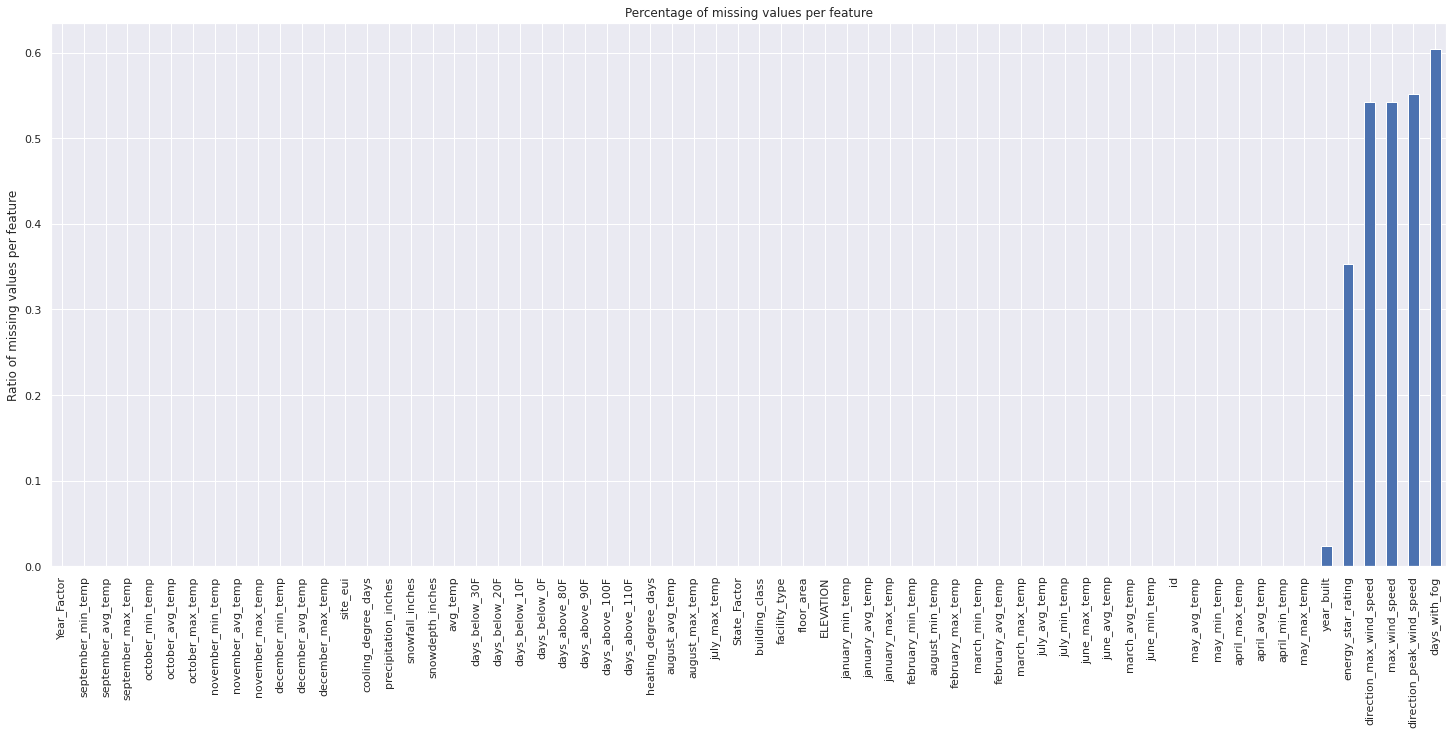

In [8]:
#view the missing values per features in percentage
train_data.isna().mean().sort_values().plot(
    kind="bar", figsize=(25, 10),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");

There are 55.2% missing values in direction_peak_wind_speed columns that are missing, 54.23% values in max_wind_speed and direction_max_wind_speed. Also 60.1% missing values from the days_with_fog columns. Those features have more than 50% missing values. So let's go ahead and drop any features with more than 15% missing values. 

In [9]:
#drop features with more than 15% missing values
train_data = train_data.dropna(thresh = train_data.shape[0] *0.85, axis=1)
train_data.shape

(75757, 59)

In [10]:
#check if there is duplicated values
train_data.duplicated().sum()

0

In [11]:
#check the remaining missing values.
train_data.isnull().sum().sum()

1837

This is great we can go ahead and fill the values since it is leass than 15%.

In [12]:
#fill all the nan values with zero
#check if there is still null values in the dataset
train_data = train_data.fillna(0, axis =1)
train_data.isnull().sum().sum()

0

In [13]:
#view the statistical summary of the data
train_data.describe()

,Year_Factor,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,...,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui,id
count,75757.000000,7.575700e+04,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,...,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000
mean,4.367755,1.659839e+05,1904.966089,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,58.486278,...,48.756511,17.447932,4.886532,0.876764,82.709809,14.058701,0.279539,0.002442,82.584693,37878.000000
std,1.471441,2.468758e+05,302.528096,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,8.414611,...,27.587124,14.469435,7.071221,2.894244,25.282913,10.943996,2.252323,0.142140,58.255403,21869.306509
min,1.000000,9.430000e+02,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,38.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.001169,0.000000
25%,3.000000,6.237900e+04,1926.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,55.000000,...,22.000000,5.000000,0.000000,0.000000,72.000000,6.000000,0.000000,0.000000,54.528601,18939.000000
50%,5.000000,9.136700e+04,1950.000000,25.000000,11.000000,34.451613,59.000000,9.000000,34.107143,61.000000,...,50.000000,11.000000,2.000000,0.000000,84.000000,12.000000,0.000000,0.000000,75.293716,37878.000000
75%,6.000000,1.660000e+05,1976.000000,42.700000,13.000000,37.322581,62.000000,20.000000,40.879310,62.000000,...,66.000000,26.000000,7.000000,0.000000,97.000000,17.000000,0.000000,0.000000,97.277534,56817.000000
max,6.000000,6.385382e+06,2015.000000,1924.500000,49.000000,64.758065,91.000000,48.000000,65.107143,89.000000,...,170.000000,93.000000,59.000000,31.000000,260.000000,185.000000,119.000000,16.000000,997.866120,75756.000000


In [14]:
#let's view the columns
train_data.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'ELEVATION', 'january_min_temp',
       'january_avg_temp', 'january_max_temp', 'february_min_temp',
       'february_avg_temp', 'february_max_temp', 'march_min_temp',
       'march_avg_temp', 'march_max_temp', 'april_min_temp', 'april_avg_temp',
       'april_max_temp', 'may_min_temp', 'may_avg_temp', 'may_max_temp',
       'june_min_temp', 'june_avg_temp', 'june_max_temp', 'july_min_temp',
       'july_avg_temp', 'july_max_temp', 'august_min_temp', 'august_avg_temp',
       'august_max_temp', 'september_min_temp', 'september_avg_temp',
       'september_max_temp', 'october_min_temp', 'october_avg_temp',
       'october_max_temp', 'november_min_temp', 'november_avg_temp',
       'november_max_temp', 'december_min_temp', 'december_avg_temp',
       'december_max_temp', 'cooling_degree_days', 'heating_degree_days',
       'precipitation_inches', 'snowfall_inches', 'snowdepth_inche

In [15]:
#checking for columns with unique value
train_data[[col for col in train_data.columns if train_data[col].dtype == 'object']].describe()

,State_Factor,building_class,facility_type
count,75757,75757,75757
unique,7,2,60
top,State_6,Residential,Multifamily_Uncategorized
freq,50840,43558,39455


In [16]:
#view the target
train_data['site_eui']

0        248.682615
1         26.500150
2         24.693619
3         48.406926
4          3.899395
            ...    
75752    132.918411
75753     39.483672
75754     48.404398
75755    592.022750
75756     29.154684
Name: site_eui, Length: 75757, dtype: float64

In [17]:
#let us drop the columns we will not be including in the dataset, then view it. 
train_data=train_data.drop(['id'],axis=1)
train_data.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,2.4,36,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,1.8,36,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,1.8,36,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,1.8,36,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,2.4,36,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,3.899395


In [18]:
train_data['site_eui'].describe()

count    75757.000000
mean        82.584693
std         58.255403
min          1.001169
25%         54.528601
50%         75.293716
75%         97.277534
max        997.866120
Name: site_eui, dtype: float64

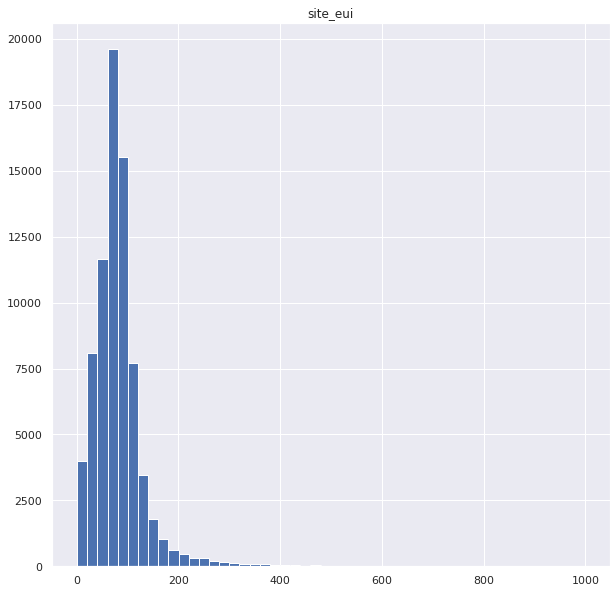

In [19]:
#visualize the target
train_data.hist(column='site_eui', bins = 50, figsize=(10,10))
plt.show()

As you can see that the target is positively skewed to the right showing that there are outliers. Let's go ahead and check the boundary values.

In [20]:
#check the boundary values
print("Highest allowed",train_data['site_eui'].mean() + 3 *train_data['site_eui'].std())
print("Lowest allowed",train_data['site_eui'].mean() - 3 *train_data['site_eui'].std())

Highest allowed 257.35090061384864
Lowest allowed -92.18151534140623


Now let's find the outliers

In [21]:
#check for outliers
outliers = train_data[(train_data['site_eui'] > 257.35) | (train_data['site_eui'] > -92.18)]
outliers

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,2.4,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,2.4,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,3.899395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,36.6,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,132.918411
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,36.6,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,39.483672
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,36.6,26,36.612903,48,...,47.911202,26,2,0,0,6,0,0,0,48.404398
75755,6,State_11,Commercial,Commercial_Other,53575.0,2012.0,36.6,26,36.612903,48,...,47.911202,26,2,0,0,6,0,0,0,592.022750


Now let's trim off the outliers, cap on it and then apply the capping.

In [22]:
#trimming off the outliers
train_data =train_data[(train_data['site_eui'] < 257.35)&(train_data['site_eui'] > -92.18)]
train_data

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,2.4,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,2.4,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,3.899395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75751,6,State_11,Residential,2to4_Unit_Building,28284.0,1928.0,63.1,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,70.298783
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,36.6,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,132.918411
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,36.6,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,39.483672
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,36.6,26,36.612903,48,...,47.911202,26,2,0,0,6,0,0,0,48.404398


In [23]:
#Capping on outliers
upper_limit = train_data['site_eui'].mean() + 3 *train_data['site_eui'].std()
lower_limit = train_data['site_eui'].mean() - 3 *train_data['site_eui'].std()
#Now let's apply the Capping
train_data['site_eui'] = np.where(train_data['site_eui'] > upper_limit,
                               upper_limit,np.where(train_data['site_eui'] < lower_limit,
                                                    lower_limit,train_data['site_eui']))
#reset index
train_data =train_data.reset_index(drop=True)
train_data

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,2.4,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,194.640593
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,2.4,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,3.899395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74536,6,State_11,Residential,2to4_Unit_Building,28284.0,1928.0,63.1,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,70.298783
74537,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,36.6,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,132.918411
74538,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,36.6,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,39.483672
74539,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,36.6,26,36.612903,48,...,47.911202,26,2,0,0,6,0,0,0,48.404398


In [24]:
#view the summary statistics of the target
train_data['site_eui'].describe()

count    74541.000000
mean        77.158390
std         37.446755
min          1.001169
25%         54.086698
50%         74.695355
75%         95.853973
max        194.640593
Name: site_eui, dtype: float64

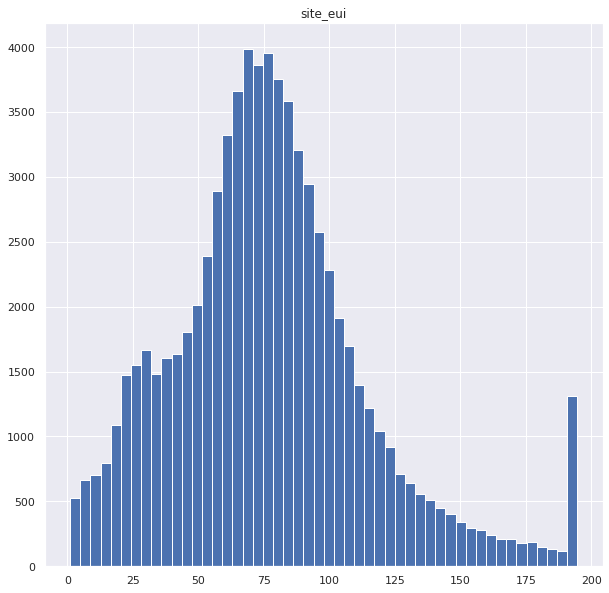

In [25]:
#Now let's plot the histogram again to see if the outlier has been removed.
train_data.hist(column='site_eui', bins = 50, figsize=(10,10))
plt.show()

Now if you look at the histogram, you will see that the target has been normalize. All outliers has been removed which give us similar data across all the data. Let's go ahead and check if there ia ny multicollinearity among the features and target.

Text(0.5, 1.0, 'MultiCollinearity Btw target and Features ')

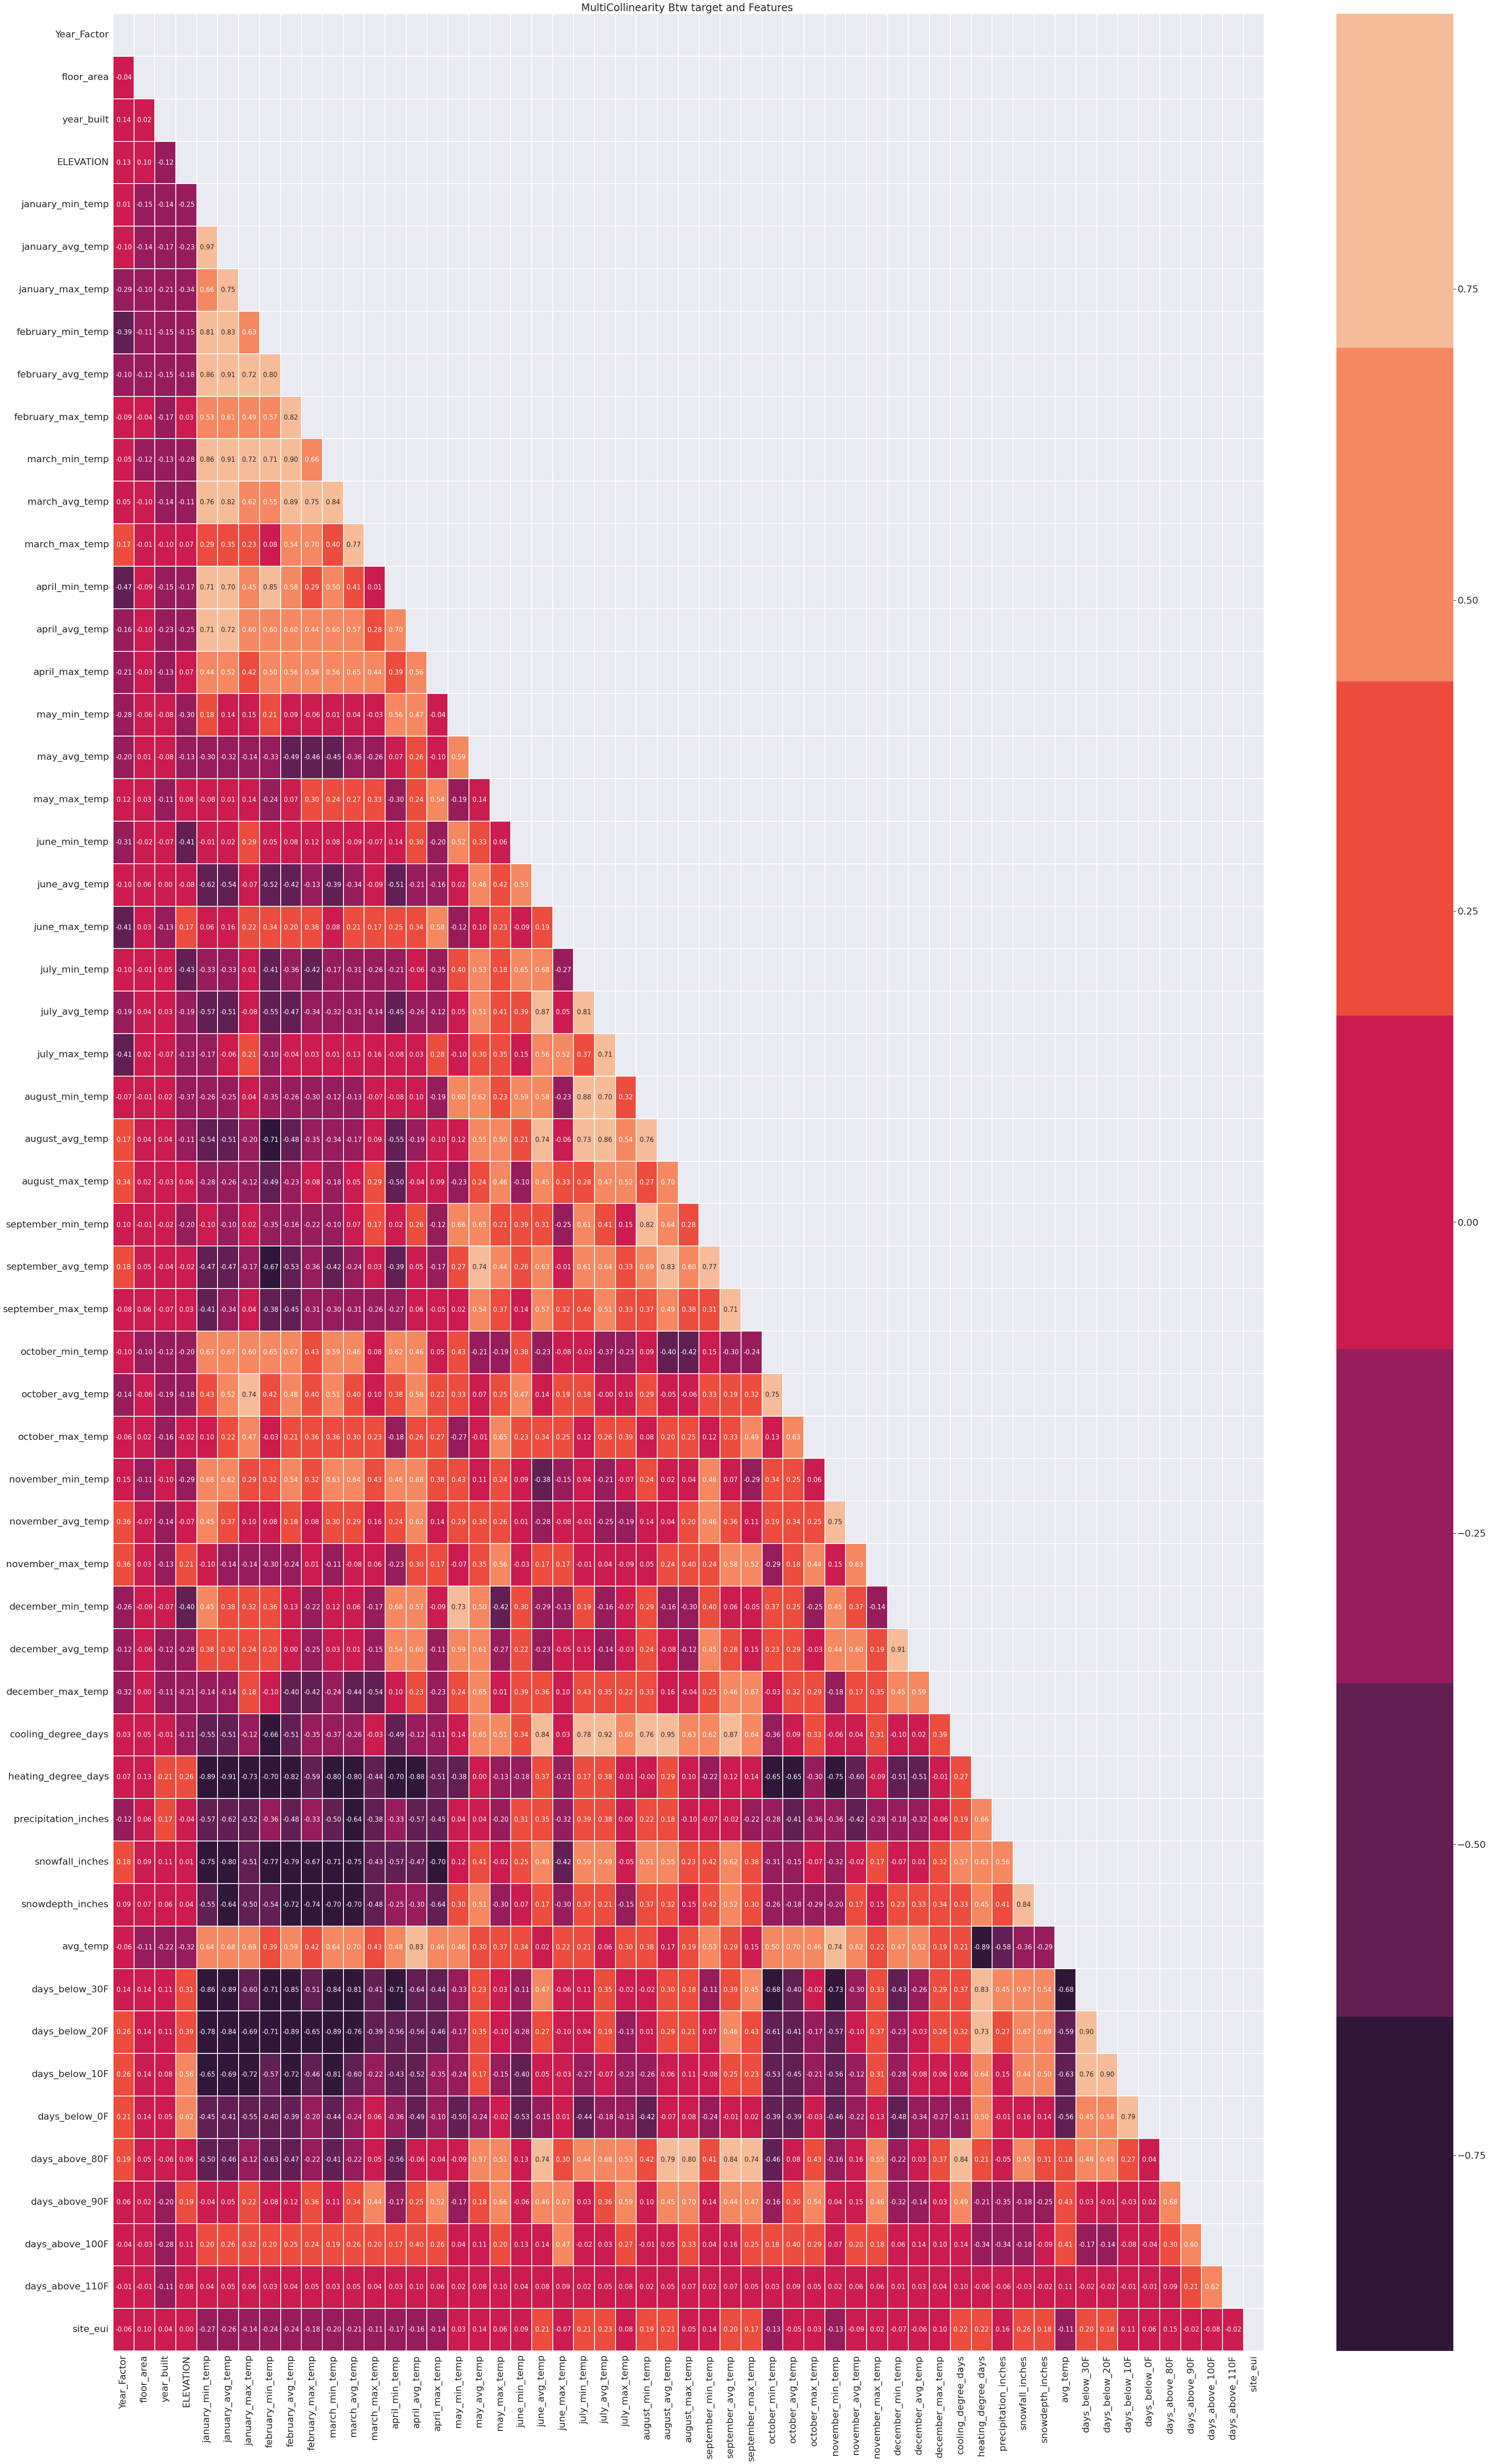

In [26]:
#let's visualize the multicolinearity among the features.
sns.set(font_scale =2)
plt.figure(figsize = (60,100))
ax = sns.heatmap(train_data.corr(),mask =np.triu(np.ones_like(train_data.corr(),dtype = bool)), 
            annot = True,cmap =sns.color_palette('rocket',7),
            linewidths=2,linecolor='white',fmt='.2f',annot_kws={"size":15})
plt.title("MultiCollinearity Btw target and Features ")

Text(0.5, 1.0, 'Correlation between the target and features')

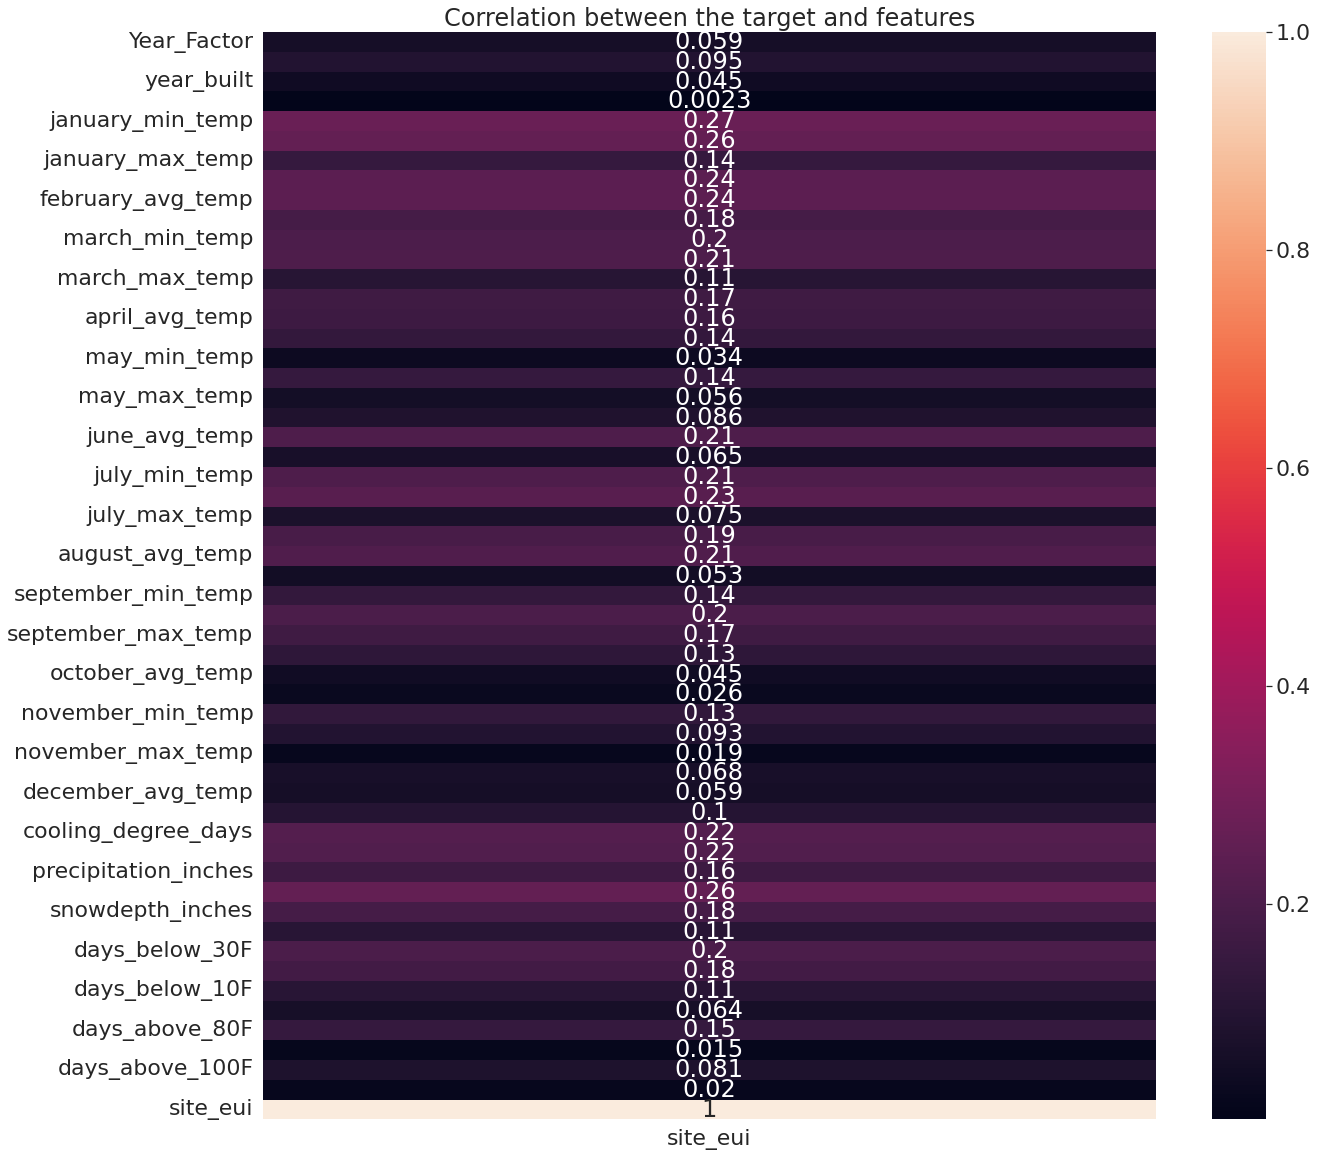

In [27]:
#Using the heatmap to view the feature that correlate with the target.
plt.figure(figsize = (20,20))
ax =sns.heatmap(abs(train_data.corr())[['site_eui']], annot = True);
plt.title("Correlation between the target and features")

Looking at the graph above you can see that there is a high multi-collinearity between the target and January minimum temperature,February average temp and the cooling degree days.Now let us go ahead and split our data into dependent and independent variables

In [28]:
#define X and y
X = train_data.drop('site_eui',axis=1)
y= train_data['site_eui']
#view the shape of the data
X.shape, y.shape

((74541, 57), (74541,))

In [29]:
#view the shape of the data
X.shape, y.shape

((74541, 57), (74541,))

In [30]:
#View the first ten rows of the dependent features
X.head(10)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,2.4,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,1.8,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,1.8,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,1.8,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,2.4,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
5,1,State_1,Commercial,Warehouse_Selfstorage,119900.0,1956.0,2.4,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
6,1,State_1,Commercial,Warehouse_Nonrefrigerated,91367.0,1982.0,2.4,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
7,1,State_1,Commercial,Warehouse_Nonrefrigerated,50422.0,1947.0,2.4,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
8,1,State_1,Commercial,Office_Uncategorized,122020.0,1929.0,2.4,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
9,1,State_1,Commercial,Office_Uncategorized,102612.0,1979.0,2.4,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0


In [31]:
#view the first ten rows of the target 
y.head(10)

0    194.640593
1     26.500150
2     24.693619
3     48.406926
4      3.899395
5      6.597715
6     12.817841
7     22.392014
8     28.199578
9     29.515952
Name: site_eui, dtype: float64

In [32]:
#let's view the unique values and classify them into it's unique categories
num_cols = []
ohe_cols = []
freq_cols =[]

for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        num_cols.append(col)
    elif X[col].nunique() < 10:
        ohe_cols.append(col)
    else:
        freq_cols.append(col)
        
#print the list of numerical columns,categorical columns and frequency columns
print(f"list of numerical columns: {num_cols}")
print("--")
print(f"list of categorical columns:{ohe_cols}")
print("--")
print(f"list of Frequency columns:{freq_cols}")

list of numerical columns: ['Year_Factor', 'floor_area', 'year_built', 'ELEVATION', 'january_min_temp', 'january_avg_temp', 'january_max_temp', 'february_min_temp', 'february_avg_temp', 'february_max_temp', 'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp', 'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp', 'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp', 'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp', 'august_avg_temp', 'august_max_temp', 'september_min_temp', 'september_avg_temp', 'september_max_temp', 'october_min_temp', 'october_avg_temp', 'october_max_temp', 'november_min_temp', 'november_avg_temp', 'november_max_temp', 'december_min_temp', 'december_avg_temp', 'december_max_temp', 'cooling_degree_days', 'heating_degree_days', 'precipitation_inches', 'snowfall_inches', 'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F', 'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F'

It seems here that we only have two categorical variables and one freq column. Now we can go ahead split the data,and scale it so that we can have equal data among the records.

In [33]:
#split the data into training and validation data. 
#we will be using the validation data to train the algorithms
#then use the test data on the final model.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# create another train data and validation data from the split
train_df = pd.concat([X_train,y_train], axis= 1)
validation_df = pd.concat([X_val,y_val], axis =1)

train_df.shape , validation_df.shape

((55905, 58), (18636, 58))

In [34]:
# set up pipeline for preprocessing 
# for numeric columns, we need to scale it
# for unique value <3 columns, we need to one hot encode it
# for unique value >3 columns, we need to frequency encode it
ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value = 0)),
    ('oh_encoder', OneHotEncoder(handle_unknown='ignore'))
])

freq_transformer = Pipeline(steps=[
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)),
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0))
])

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    
])

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols),
        ('scaler', num_transformer, num_cols)
    ])

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('ohe',
                                 Pipeline(steps=[('ohe_imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('oh_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['State_Factor', 'building_class']),
                                ('freq',
                                 Pipeline(steps=[('freq_encoder',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               min_group_size=0.05,
                                                               normalize=True)),
                                                 ('freq_imputer',
                                                  Simple...
             

Now let's go ahead and build our baseline model so that we can use the scoring to train our data and compare across other algorithms.

# Baseline Model

se the function to evaluate the baseline model.

In [35]:
#We will be using LinearRegression as the baseline model
baseline = Pipeline(steps = [('preprocessor', preprocessor),
                             ('reg', LinearRegression())])
baseline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('oh_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['State_Factor',
                                                   'building_class']),
                                                 ('freq',
                                                  Pipeline(steps=[('freq_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                  

Scores
Train score: [96.5        89.77734375 78.7109375  ... 71.42578125 62.875
 83.3359375 ]
validation score: [84.43359375 90.41015625 80.37890625 ... 83.46875    40.6484375
 38.4609375 ]
Rsquared:
Train R2: 0.1224
Validation R2: 0.1214
-----
Root Mean squared Error:
Train RMSE: 35.10
Validation RMSE: 35.04
-----
 Mean absolute Error:
Train MAE: 25.57
Validation MAE: 25.49


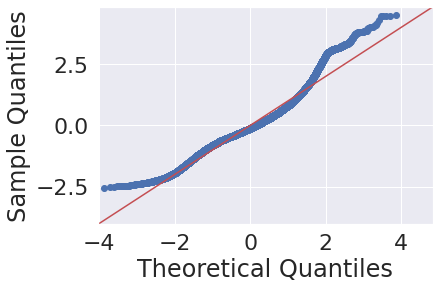

In [36]:
#Use the function to evaluate the baseline model.
#evalutae the baseline model
evaluate(baseline, X_train,y_train, X_val, y_val)

As you can see the baseline model is not doing good with a R-squared score of 12%. It simply mean that the model is over-fitting compared to the number of data sample with a very high root mean square error.That said, let's go ahead and build different model and then tune them with different parameters.

# Feature Engineering with Gridsearch cv

- #### First Model with Gridsearch

In [37]:
#Initialize the DecisionTreeRegressor
d_tree = Pipeline(steps = [('preprocessor', preprocessor),
                             ('model', DecisionTreeRegressor())])
param = [{'model__criterion':['squared_error','friedman_mse'],#gridsearch using different parameters
          'model__splitter':['best'],
          'model__max_depth': [5,10,20],
          'model__min_samples_split':[10,100],
          'model__max_features': ['auto','sqrt']}]

grid = GridSearchCV(estimator= d_tree,
                    param_grid = param, scoring= 'r2')
result = grid.fit(X_train,y_train) #fit the result on train data
result.best_params_

{'model__criterion': 'squared_error',
 'model__max_depth': 10,
 'model__max_features': 'auto',
 'model__min_samples_split': 100,
 'model__splitter': 'best'}

In [38]:
#view the best score from the parameter
result.best_score_

0.1509363262828579

Scores
Train score: [89.87174405 79.03606976 76.51879179 ... 59.75031209 13.50646496
 80.50319947]
validation score: [89.49398905 75.73540277 88.37609779 ... 79.03606976 31.92184026
 47.86117314]
Rsquared:
Train R2: 0.2001
Validation R2: 0.1493
-----
Root Mean squared Error:
Train RMSE: 33.51
Validation RMSE: 34.48
-----
 Mean absolute Error:
Train MAE: 24.13
Validation MAE: 24.74


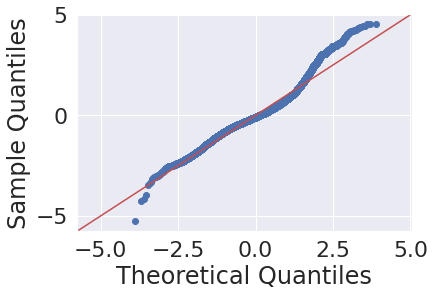

In [39]:
#evaluate the best estimator
evaluate(result.best_estimator_,X_train,y_train, X_val, y_val)

The Rsquare is showing a variance of 20% on the training data and 15% on the validation data with a Validation RMSE OF 34.48

- #### Let's build another regressor model using gridsearch cv.

In [40]:
#Initialize the Gradient boost Regressor
gbr = Pipeline(steps = [('preprocessor', preprocessor),
                             ('gbr model',GradientBoostingRegressor())])
param = [{'gbr model__loss': ['squared_error', 'quantile'],
          'gbr model__max_features':['sqrt','auto','log2']}]

grid = GridSearchCV(estimator= gbr,
                    param_grid = param, scoring= 'r2')
result = grid.fit(X_train,y_train)
result.best_params_

{'gbr model__loss': 'squared_error', 'gbr model__max_features': 'auto'}

In [41]:
result.best_score_

0.16109097733026612

Scores
Train score: [96.12236322 84.25701864 79.88435436 ... 63.0192793  57.78336721
 84.18092109]
validation score: [86.40701018 84.0976051  82.74787301 ... 78.98677579 41.04860251
 32.09199956]
Rsquared:
Train R2: 0.1708
Validation R2: 0.1646
-----
Root Mean squared Error:
Train RMSE: 34.12
Validation RMSE: 34.17
-----
 Mean absolute Error:
Train MAE: 24.62
Validation MAE: 24.61


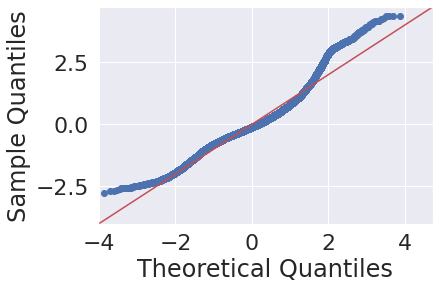

In [42]:
evaluate(result.best_estimator_,X_train,y_train, X_val, y_val)

In [43]:
rf = Pipeline(steps = [('preprocessor', preprocessor),
                        ('rf model',RandomForestRegressor(criterion = 'squared_error',
                                                          max_features='auto',min_samples_split=10,n_estimators= 100))])
rf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('oh_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['State_Factor',
                                                   'building_class']),
                                                 ('freq',
                                                  Pipeline(steps=[('freq_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                  

In [44]:
cross_validate(rf,X_train,y_train,return_train_score =True)

{'fit_time': array([36.30529284, 36.46800923, 36.10314727, 36.43554401, 36.74697661]),
 'score_time': array([0.29370642, 0.27953482, 0.29474235, 0.29934192, 0.28232646]),
 'test_score': array([0.26177258, 0.26302924, 0.2657659 , 0.25604896, 0.27193186]),
 'train_score': array([0.69350116, 0.69163352, 0.69297881, 0.69321758, 0.6924346 ])}

Scores
Train score: [81.87481535 47.54920889 75.12886338 ... 51.80318017 16.23708388
 81.09300338]
validation score: [98.73683702 71.86182414 73.98798409 ... 71.52932537 40.90070923
 57.46570578]
Rsquared:
Train R2: 0.7048
Validation R2: 0.2971
-----
Root Mean squared Error:
Train RMSE: 20.36
Validation RMSE: 31.34
-----
 Mean absolute Error:
Train MAE: 14.57
Validation MAE: 22.41


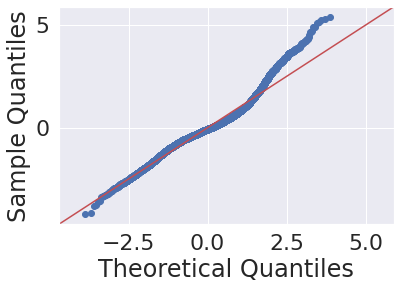

In [45]:
evaluate(rf,X_train,y_train, X_val, y_val)

In [46]:
test_data = pd.read_csv("/kaggle/input/widsdatathon2022/test.csv")
test_data = test_data.fillna(test_data.mean())
prediction = rf.predict(test_data)
df = pd.DataFrame({'Predicted': prediction})
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,Predicted
0,134.659536
1,86.404367
2,67.926979
3,65.926983
4,141.135435
...,...
9700,33.056974
9701,45.901692
9702,40.525534
9703,34.762080


The Random Forest Regressor was able to outperformed more than the other models with a R^2 of 82% on training data and 31% on validation data with a root mean square error of 31.15. I will go ahead and feature engineer the model and then use it to predict the test data.

In [47]:
submission =pd.read_csv("/kaggle/input/widsdatathon2022/sample_solution.csv")
submission['site_eui']= prediction
submission.to_csv("submission.csv",index=False)